In [38]:
import pandas as pd
from pathlib import Path
import shutil

# ====== Config ======
IMAGE_RATINGS_CSV = "result/image/image_rating_pairs.csv"
PARTICIPANT_INFO_CSV = "participant_info.csv"
OUTPUT_DIR = Path("output_final")
PROMPT_DIR = OUTPUT_DIR / "prompt"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PROMPT_DIR.mkdir(parents=True, exist_ok=True)

# ====== Load Data ======
image_ratings_df = pd.read_csv(IMAGE_RATINGS_CSV)
participant_info_df = pd.read_csv(PARTICIPANT_INFO_CSV)

# 날짜 변환 (최신 순 정렬을 위해)
image_ratings_df["rating_timestamp"] = pd.to_datetime(
    image_ratings_df["rating_timestamp"], errors="coerce"
)

# ====== iteration number 추가 ======
image_ratings_df = image_ratings_df.sort_values("rating_timestamp")
image_ratings_df["iter_number"] = image_ratings_df.groupby(
    ["person", "system_type"]
).cumcount() + 1  # 1부터 시작

# 결과 기록용 리스트
final_records = []

# ====== Process per participant & system ======
for (person, system_type), group in image_ratings_df.groupby(["person", "system_type"]):
    # 1. 최고 rating 찾기
    max_rating = group["rating"].max()
    max_group = group[group["rating"] == max_rating]

    # 2. tie-break: rating_timestamp 최신 것
    final_row = max_group.sort_values("rating_timestamp").iloc[-1]

    # 3. target info 가져오기
    row = participant_info_df[
        participant_info_df["participants"].str.lower() == person.lower()
    ]
    if not row.empty:
        if system_type.lower() == "system1":
            target_info = row.iloc[0]["System 1"]
        else:
            target_info = row.iloc[0]["System 2"]
    else:
        target_info = "NA"

    # 4. 파일명 구성
    participant_id = person
    system_info = system_type
    rating_val = final_row["rating"]
    iter_number = final_row["iter_number"]
    target_info_str = str(target_info)

    new_basename = f"{participant_id}_{system_info}_{target_info_str}_{rating_val}_{iter_number}"
    new_img = OUTPUT_DIR / f"{new_basename}.png"
    new_prompt = PROMPT_DIR / f"{new_basename}.json"

    # 5. 이미지 복사
    src_path = final_row.get("image_path", None)
    if pd.isna(src_path) or not Path(src_path).exists():
        src_path = final_row.get("image_path_raw", None)

    if src_path and Path(src_path).exists():
        shutil.copy(src_path, new_img)
        print(f"[OK-IMG] {new_img.name}")

        # 6. prompt.json 경로 추정 및 복사
        prompt_src = Path(str(src_path).replace("image.png", "prompt.json"))
        if prompt_src.exists():
            shutil.copy(prompt_src, new_prompt)
            print(f"[OK-PROMPT] {new_prompt.name}")
        else:
            print(f"[MISSING-PROMPT] {prompt_src}")

        # 결과 기록
        final_records.append({
            "participant": participant_id,
            "system_type": system_info,
            "target_info": target_info_str,
            "rating": rating_val,
            "iter_number": iter_number,
            "src_image": str(src_path),
            "dst_image": str(new_img),
            "src_prompt": str(prompt_src),
            "dst_prompt": str(new_prompt) if prompt_src.exists() else None
        })
    else:
        print(f"[MISSING-IMG] {person}-{system_type}: {src_path}")

# ====== Save mapping table ======
df_final = pd.DataFrame(final_records)
df_final.to_csv(OUTPUT_DIR / "final_outputs_mapping.csv", index=False)
print(f"\n[INFO] Mapping table saved to {OUTPUT_DIR/'final_outputs_mapping.csv'}")


[OK-IMG] P1_system1_target2_6.0_1.png
[OK-PROMPT] P1_system1_target2_6.0_1.json
[OK-IMG] P1_system2_target1_6.0_2.png
[OK-PROMPT] P1_system2_target1_6.0_2.json
[OK-IMG] P10_system1_target2_6.0_1.png
[OK-PROMPT] P10_system1_target2_6.0_1.json
[OK-IMG] P10_system2_target1_5.0_1.png
[OK-PROMPT] P10_system2_target1_5.0_1.json
[OK-IMG] P11_system1_target1_3.0_4.png
[OK-PROMPT] P11_system1_target1_3.0_4.json
[OK-IMG] P11_system2_target2_6.0_2.png
[OK-PROMPT] P11_system2_target2_6.0_2.json
[OK-IMG] P12_system1_target2_3.0_2.png
[OK-PROMPT] P12_system1_target2_3.0_2.json
[OK-IMG] P12_system2_target1_4.0_2.png
[OK-PROMPT] P12_system2_target1_4.0_2.json
[OK-IMG] P2_system1_target2_5.0_3.png
[OK-PROMPT] P2_system1_target2_5.0_3.json
[OK-IMG] P2_system2_target1_4.0_4.png
[OK-PROMPT] P2_system2_target1_4.0_4.json
[OK-IMG] P3_system1_target1_4.0_3.png
[OK-PROMPT] P3_system1_target1_4.0_3.json
[OK-IMG] P3_system2_target2_6.0_1.png
[OK-PROMPT] P3_system2_target2_6.0_1.json
[OK-IMG] P4_system1_target1_

=== Paired t-test ===
T-statistic = -1.254, p-value = 0.23599

=== Wilcoxon signed-rank test ===
W-statistic = 16.000, p-value = 0.22317
=== 평균 rating 비교 ===
system_type
system1    4.833333
system2    5.333333
Name: rating, dtype: float64

=== 표준편차 ===
system_type
system1    1.267304
system2    1.154701
Name: rating, dtype: float64

=== 참가자별 rating ===
system_type  system1  system2
person                       
P1               6.0      6.0
P10              6.0      5.0
P11              3.0      6.0
P12              3.0      4.0
P2               5.0      4.0
P3               4.0      6.0
P4               5.0      5.0
P5               7.0      6.0
P6               4.0      6.0
P7               6.0      7.0
P8               4.0      3.0
P9               5.0      6.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


<Figure size 600x400 with 0 Axes>

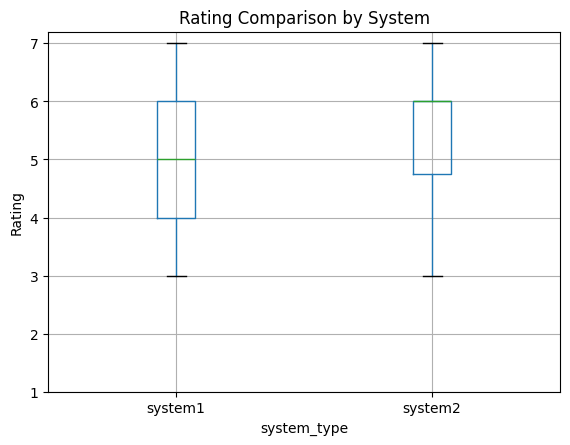

In [36]:
import pandas as pd
from pathlib import Path
import scipy.stats as stats
import matplotlib.pyplot as plt

# ====== Load parsed results again (같은 DataFrame pivot 사용) ======
records = []
for f in Path("output_final").glob("*.png"):
    parts = f.stem.split("_")
    if len(parts) < 4:
        continue
    participant_id = parts[0]
    system_info = parts[1]
    rating = float(parts[-2])
    target_info = "_".join(parts[2:-2])
    records.append({"person": participant_id, "system_type": system_info, "rating": rating})

df = pd.DataFrame(records)
pivot = df.pivot(index="person", columns="system_type", values="rating").dropna()

# ====== Paired t-test ======
t_stat, p_val_ttest = stats.ttest_rel(pivot["system1"], pivot["system2"])

# ====== Wilcoxon signed-rank test ======
w_stat, p_val_wilcox = stats.wilcoxon(pivot["system1"], pivot["system2"])

print("=== Paired t-test ===")
print(f"T-statistic = {t_stat:.3f}, p-value = {p_val_ttest:.5f}")

print("\n=== Wilcoxon signed-rank test ===")
print(f"W-statistic = {w_stat:.3f}, p-value = {p_val_wilcox:.5f}")

# ====== system별 통계 비교 ======
print("=== 평균 rating 비교 ===")
print(df.groupby("system_type")["rating"].mean())

print("\n=== 표준편차 ===")
print(df.groupby("system_type")["rating"].std())

print("\n=== 참가자별 rating ===")
pivot = df.pivot(index="person", columns="system_type", values="rating")
print(pivot)

# ====== 시각화 ======
plt.figure(figsize=(6,4))
df.boxplot(column="rating", by="system_type")
plt.title("Rating Comparison by System")
plt.suptitle("")  # remove auto title
plt.ylabel("Rating")
plt.yticks(range(1, 8, 1))

plt.show()
